In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import jax.numpy as jnp
import xgboost as xgb
import jax
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import anndata

/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/scanpy/_utils/__init__.py:27: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/scanpy/__init__.py:36: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/home/cachris/.conda/envs/sc-env4/lib/python3.12/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [5]:
def get_pert_vectors(adata, cell_line_key = 'cell_name', drug_key = 'drugname_drugconc', control_treatment ="[('DMSO_TF', 0.0, 'uM')]" ):
    # Extract metadata and group labels
    meta_df = adata.obs[[cell_line_key, drug_key ]].copy()
    meta_df['group'] = meta_df[cell_line_key].astype(str) + '|' + meta_df[drug_key].astype(str)
    # Map groups to integer indices
   
    group_idx, unique_groups = pd.factorize(meta_df['group'])
    # Then run your code
    # Extract metadata and group labels
    meta_df = adata.obs[[cell_line_key,  drug_key ]].copy()
    meta_df['group'] = meta_df[cell_line_key].astype(str) + '|' + meta_df[drug_key ].astype(str)
    adata.obs['group'] = adata.obs[cell_line_key].astype(str) + '|' + adata.obs[drug_key ].astype(str)
    print('here')
    # Map groups to integer indices
    group_idx, unique_groups = pd.factorize(meta_df['group'])
    # X_jax: (n_cells, n_dims)
    # group_idx: int array of length n_cells (e.g., from pd.factorize)
    X_jax = jnp.array(adata.X.astype('float32'))
    print('here')
    group_idx = jnp.array(group_idx)
    n_groups = len(unique_groups)
    sums = jax.ops.segment_sum(X_jax, group_idx, n_groups)
    counts = jax.ops.segment_sum(jnp.ones((X_jax.shape[0], 1)), group_idx, n_groups)
    centroids = sums / counts
    # Back to Pandas to identify DMSO indices
    group_labels = pd.Series(unique_groups)
    cell_types = group_labels.str.split('|').str[0]
    perts = group_labels.str.split('|').str[1]

    # Find the index of each DMSO centroid by cell_type
    dmso_idx = (perts == control_treatment)

    # Convert boolean mask to indices for JAX
    dmso_indices = np.where(dmso_idx.values)[0]  # Convert pandas boolean to JAX indices
    dmso_centroids = centroids[dmso_indices]

    # Match non-DMSO centroids to their corresponding DMSO by cell_type
    pert_indices = np.where(~dmso_idx.values)[0]  # Also convert this to JAX indices
    pert_cell_types = cell_types[~dmso_idx].values

    # Build a lookup: cell_type → index in dmso_centroids
    dmso_cell_types = cell_types[dmso_idx].values
    dmso_cell_type_to_idx = dict(zip(dmso_cell_types, dmso_indices))

    # Get DMSO centroid for each perturbation group
    dmso_for_pert = np.stack([
        centroids[dmso_cell_type_to_idx[ct]] for ct in pert_cell_types
    ])

    # Compute perturbation vectors
    pert_vectors = centroids[pert_indices] - dmso_for_pert
    reference_df = pd.DataFrame({
    'variable': cell_types,
    'drug': perts,
    'order': range(len(cell_types))
    })
    return pert_vectors, reference_df

In [6]:
a549_ground_truth = sc.read_h5ad('/home/cachris/A549_gene_sim/original.h5ad')
a549_ground_truth.X = a549_ground_truth.obsm['X_hvg']
real_vectors, ref_real = get_pert_vectors(a549_ground_truth)
del a549_ground_truth

here
here


In [7]:
survival_values = pd.read_csv('/large_storage/ctc/public/tahoe/survival_data/log2fc_survivals_averaged_across_plate.csv')
survival_values.index = survival_values['drug']
survival_values = pd.DataFrame(survival_values['A549'])
survival_values['drugname_drugconc'] = survival_values.index.to_series().apply(
    lambda x: f"[('{x.split('_')[0]}', {x.split('_')[1]}, 'uM')]"
)

In [8]:
ref_real = pd.merge(
    ref_real,
    survival_values,
    left_on='drug',
    right_on='drugname_drugconc',
    how='left',
    sort=False
)

In [9]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
ref_real = ref_real[ref_real['drug'] != "[('DMSO_TF', 0.0, 'uM')]"]

In [13]:
import random
drugs = ref_real['drug'].str.split(',').str[0].unique()
drugs = [x[5:] for x in drugs]
drugs = random.sample(list(drugs), 15)
print(drugs)
drugs_regex = '|'.join(drugs)

["ntamapimod'", "TO-253'", "-8353'", "licylic acid'", "rbamine (dihydrochloride)'", "bociclib'", "ratinib'", "motinib'", "tracycline (hydrochloride)'", "tecavir (monohydrate)'", "inestrol'", "mesulide'", "butin'", "droxyurea'", "nofibrate'"]


In [14]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
valid_mask = ~ref_real['A549'].isna()
# Apply the same mask to both
x = real_vectors[valid_mask.values, :]
y = ref_real['A549'][valid_mask].values
train_mask =  ~(ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['A549'].isna())
X_train = real_vectors[train_mask.values, :]
y_train = ref_real['A549'][train_mask].values
test_mask = (ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['A549'].isna())
X_test = real_vectors[test_mask.values, :]
y_test = ref_real['A549'][test_mask].values
# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit SVM
svm = SVR(kernel='rbf')  # or 'rbf', 'poly', etc.
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)

/tmp/ipykernel_2739616/2432298432.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  train_mask =  ~(ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['A549'].isna())
/tmp/ipykernel_2739616/2432298432.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  test_mask = (ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['A549'].isna())


In [15]:
# Regression metrics
print("SVR Regression Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.4f}")
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import pearsonr

r, p = pearsonr(y_test, y_pred)

print(f"Pearson r  = {r:.4f}")
print(f"Pearson r² = {r**2:.4f}")
print(f"p-value    = {p:.4e}")

SVR Regression Metrics:
R² Score: 0.1398
Mean Squared Error: 0.0079
Root Mean Squared Error: 0.0888
Mean Absolute Error: 0.0659
Pearson r  = 0.4015
Pearson r² = 0.1612
p-value    = 8.4120e-03


In [16]:
a549_preds = sc.read_h5ad('/home/cachris/A549_gene_sim/first_pass_preds.h5ad')
vars = np.load('/large_storage/ctc/userspace/aadduri/datasets/tahoe_19k_to_2k_names.npy', allow_pickle=True)
a549_preds.X = a549_preds.obsm['X_hvg']

In [17]:
pred_vectors, ref_pred = get_pert_vectors(a549_preds)
del a549_preds


here
here


In [18]:
ref_pred

,variable,drug,order
0,A549,AAAS,0
1,A549,AAMP,1
2,A549,AAR2,2
3,A549,AARS,3
4,A549,AARS2,4
...,...,...,...
2019,A549,ZRANB2,2019
2020,A549,ZRSR2,2020
2021,A549,ZW10,2021
2022,A549,ZWINT,2022


In [19]:
ref_pred = ref_pred[ref_pred['drug'] != "[('DMSO_TF', 0.0, 'uM')]"]

In [20]:
ref_pred 

,variable,drug,order
0,A549,AAAS,0
1,A549,AAMP,1
2,A549,AAR2,2
3,A549,AARS,3
4,A549,AARS2,4
...,...,...,...
2018,A549,ZNRD1,2018
2019,A549,ZRANB2,2019
2020,A549,ZRSR2,2020
2021,A549,ZW10,2021


In [21]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Apply the same mask to both
x = pred_vectors

X_test_scaled = scaler.transform(x)


# Make predictions
y_pred = svm.predict(x)


In [22]:
y_pred = pd.Series(y_pred)
y_pred.index = ref_pred['drug']
y_pred.sort_values().head(20)

drug
PSMA4    -0.021915
PSMB3    -0.021897
PSMC4    -0.021860
PSMB6    -0.021814
WEE1     -0.021751
PSMC2    -0.021641
PSMA3    -0.021637
FTSJ3    -0.021579
PSMC5    -0.021575
PSMC1    -0.021492
PSMB2    -0.021490
PSMD11   -0.021473
PSMB5    -0.021364
PSMB1    -0.021225
RPL35A   -0.021092
SMU1     -0.021082
PSMD14   -0.021055
EIF2S1   -0.021051
RPL12    -0.020933
NUF2     -0.020834
dtype: float64

In [23]:
A549_preds = y_pred

In [24]:
bt_ground_truth = sc.read_h5ad('/home/cachris/HCT15_gene_sim/original.h5ad')
bt_ground_truth.X = bt_ground_truth.obsm['X_hvg']
real_vectors, ref_real = get_pert_vectors(bt_ground_truth)
del bt_ground_truth

here
here


In [25]:
survival_values = pd.read_csv('/large_storage/ctc/public/tahoe/survival_data/log2fc_survivals_averaged_across_plate.csv')
survival_values.index = survival_values['drug']
survival_values = pd.DataFrame(survival_values['HCT15'])
survival_values['drugname_drugconc'] = survival_values.index.to_series().apply(
    lambda x: f"[('{x.split('_')[0]}', {x.split('_')[1]}, 'uM')]"
)

In [26]:
ref_real = pd.merge(
    ref_real,
    survival_values,
    left_on='drug',
    right_on='drugname_drugconc',
    how='left',
    sort=False
)

In [27]:
ref_real = ref_real[ref_real['drug'] != "[('DMSO_TF', 0.0, 'uM')]"]

In [28]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
valid_mask = ~ref_real['HCT15'].isna()
# Apply the same mask to both
x = real_vectors[valid_mask.values, :]
y = ref_real['HCT15'][valid_mask].values
train_mask =  ~(ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['HCT15'].isna())
X_train = real_vectors[train_mask.values, :]
y_train = ref_real['HCT15'][train_mask].values
test_mask = (ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['HCT15'].isna())
X_test = real_vectors[test_mask.values, :]
y_test = ref_real['HCT15'][test_mask].values
# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit SVM
svm = SVR(kernel='rbf')  # or 'rbf', 'poly', etc.
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm.predict(X_test_scaled)

/tmp/ipykernel_2739616/55979923.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  train_mask =  ~(ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['HCT15'].isna())
/tmp/ipykernel_2739616/55979923.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  test_mask = (ref_real['drug'].str.contains(drugs_regex)) & ~(ref_real['HCT15'].isna())


In [29]:
bt_preds = sc.read_h5ad('/home/cachris//HCT15_gene_sim/first_pass_preds.h5ad')
vars = np.load('/large_storage/ctc/userspace/aadduri/datasets/tahoe_19k_to_2k_names.npy', allow_pickle=True)
bt_preds.X = bt_preds.obsm['X_hvg']
pred_vectors, ref_pred = get_pert_vectors(bt_preds)
del bt_preds

here
here


In [30]:
x = pred_vectors

X_test_scaled = scaler.transform(x)


# Make predictions
y_pred = svm.predict(x)

In [31]:
ref_pred = ref_pred[ref_pred['drug'] != "[('DMSO_TF', 0.0, 'uM')]"]

In [32]:
y_pred = pd.Series(y_pred)
y_pred.index = ref_pred['drug']
y_pred.sort_values().head(20)

drug
MTPAP       0.023122
NEDD8       0.023182
TFAM        0.023205
LRPPRC      0.023213
OPA1        0.023267
CACTIN      0.023342
LONP1       0.023346
POLRMT      0.023427
SSBP1       0.023487
TFIP11      0.023488
ZC3H18      0.023503
ATP6V1A     0.023504
CAST        0.023515
ELOF1       0.023528
TPT1        0.023538
PRORP       0.023600
ATP6V1G1    0.023615
SUPV3L1     0.023623
TRMT10C     0.023623
ELAC2       0.023629
dtype: float64

In [33]:
all_preds = pd.DataFrame({'A549' : A549_preds , 'HCT15' : y_pred})

In [34]:
all_preds['diff'] = all_preds['A549'].astype(float) - all_preds['HCT15'].astype(float) 

In [35]:
all_preds.sort_values('diff').tail(40)

,A549,HCT15,diff
drug,,,
AIFM1,-0.019019,0.023773,-0.042792
ATP6V1C1,-0.019039,0.023749,-0.042788
VPS72,-0.019018,0.023766,-0.042784
TBPL1,-0.019056,0.023727,-0.042783
PTPMT1,-0.019025,0.023753,-0.042778
USP19,-0.018950,0.023826,-0.042776
MCL1,-0.018964,0.023807,-0.042771
GPS2,-0.019038,0.023731,-0.042770
PNPT1,-0.018980,0.023785,-0.042765


In [36]:
cell_line_mapping = {'A549': 'ACH-000681','HCT15': 'ACH-000997' }

In [37]:
depmap = pd.read_csv('/home/cachris/CRISPRGeneEffect.csv.gz', index_col = 0)
depmap = depmap.T[['ACH-000681','ACH-000997' ]]

In [38]:
depmap

,ACH-000681,ACH-000997
A1BG (1),-0.061157,0.063689
A1CF (29974),-0.022389,-0.285229
A2M (2),-0.004080,0.006588
A2ML1 (144568),-0.007541,0.242971
A3GALT2 (127550),-0.041479,0.047620
...,...,...
ZYG11A (440590),0.028194,-0.008451
ZYG11B (79699),-0.219946,-0.064843
ZYX (7791),0.139457,0.067396
ZZEF1 (23140),-0.247795,-0.149798


In [39]:
all_preds

,A549,HCT15,diff
drug,,,
AAAS,-0.019162,0.024189,-0.043351
AAMP,-0.019789,0.026107,-0.045895
AAR2,-0.019161,0.024306,-0.043468
AARS,-0.020822,0.027859,-0.048681
AARS2,-0.019187,0.024392,-0.043579
...,...,...,...
ZNRD1,-0.019311,0.024308,-0.043619
ZRANB2,-0.019120,0.024042,-0.043162
ZRSR2,-0.019058,0.024027,-0.043085


In [40]:
depmap['diff'] = depmap['ACH-000681'] - depmap['ACH-000997']

In [41]:
depmap['drug'] = depmap.index.str.split(' ').str[0]

In [42]:
merged = pd.merge(depmap, all_preds, on = 'drug')
merged

,ACH-000681,ACH-000997,diff_x,drug,A549,HCT15,diff_y
0,-0.280334,0.088375,-0.368709,AAAS,-0.019162,0.024189,-0.043351
1,-1.299317,-2.460132,1.160815,AAMP,-0.019789,0.026107,-0.045895
2,-0.205379,-0.508050,0.302671,AAR2,-0.019161,0.024306,-0.043468
3,-0.714555,-0.343622,-0.370933,AARS2,-0.019187,0.024392,-0.043579
4,-0.184860,-0.439974,0.255114,AASDHPPT,-0.019220,0.024188,-0.043408
...,...,...,...,...,...,...,...
1948,-0.869152,-0.683099,-0.186054,ZNHIT6,-0.019525,0.025271,-0.044796
1949,-0.242852,-0.242288,-0.000564,ZRANB2,-0.019120,0.024042,-0.043162
1950,-0.453891,-2.279337,1.825446,ZRSR2,-0.019058,0.024027,-0.043085
1951,-0.308233,-0.419522,0.111289,ZW10,-0.019291,0.024256,-0.043548


Text(0, 0.5, 'predicted differences')

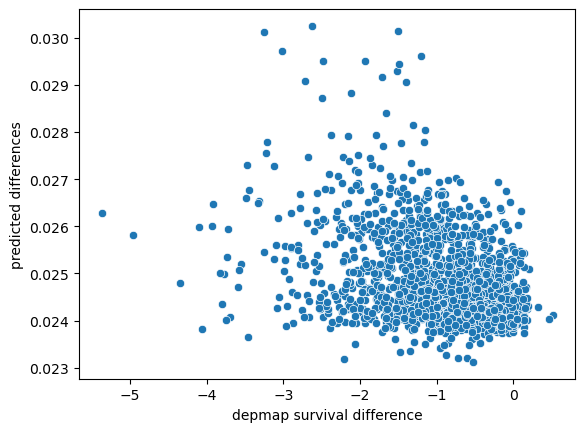

In [43]:
sns.scatterplot(x = merged['ACH-000997'],y =  merged['HCT15'])
plt.xlabel('depmap survival difference')
plt.ylabel('predicted differences')

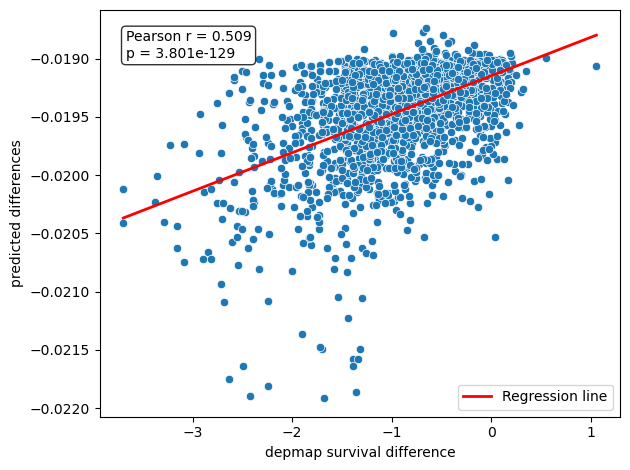

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Create the scatter plot
sns.scatterplot(x=merged['ACH-000681'], y=merged['A549'])

# Calculate regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(merged['ACH-000681'], merged['A549'])
line_x = np.array([merged['ACH-000681'].min(), merged['ACH-000681'].max()])
line_y = slope * line_x + intercept

# Plot regression line
plt.plot(line_x, line_y, color='red', linewidth=2, label=f'Regression line')

# Add Pearson r and p-value to the plot
plt.text(0.05, 0.95, f'Pearson r = {r_value:.3f}\np = {p_value:.3e}', 
         transform=plt.gca().transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('depmap survival difference')
plt.ylabel('predicted differences')
plt.legend()
plt.tight_layout()
plt.savefig('survival_predictions_depmap.pdf')
plt.savefig('survival_predictions_depmap.png')
plt.show()

In [ ]:
from scipy import stats

In [245]:
stats.pearsonr(merged['ACH-000681'],  merged['A549'])

PearsonRResult(statistic=0.4903023701213771, pvalue=1.1973373594417428e-118)

In [246]:
r2_score(merged['ACH-000681'],  merged['A549'])

-1.6910839594202702

Text(0, 0.5, 'predicted differences')

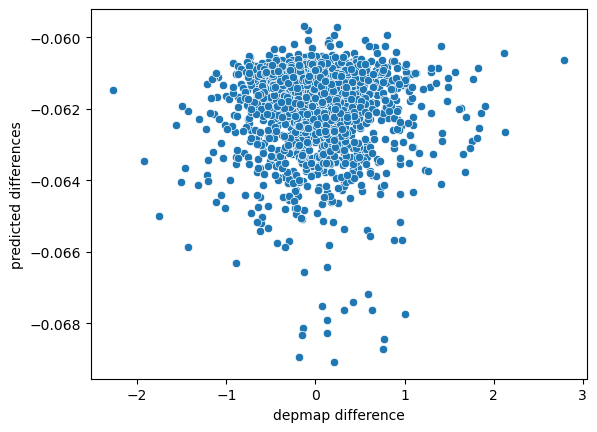

In [247]:
sns.scatterplot(x = merged['diff_x'],y =  merged['diff_y'])
plt.xlabel('depmap difference')
plt.ylabel('predicted differences')

In [166]:
!pip install depmap

/home/cachris/.conda/envs/sc-env4/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
from depmap import DepMap

# Initialize client
depmap = DepMap()

# Load the public dataset (latest release)
depmap.load_public()  # downloads ~100MB of data into ~/.depmap/

# List available datasets
depmap.datasets.keys()


ModuleNotFoundError: No module named 'depmap'

In [160]:
url = "https://ndownloader.figshare.com/files/43566496"  # CRISPR gene effect (DepMap 24Q2)
depmap = pd.read_csv(url)

HTTPError: HTTP Error 404: Not Found